# Classically-Boosted Variational Quantum Eigensolver

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
from matplotlib import pyplot as plt
from scipy import linalg

In [2]:
# Define the molecular Hamiltonian
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])
basis_set = "sto-3g"
electrons = 2
orbitals = 2
Hamiltonian, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=0,
    mult=1,
    basis=basis_set,
    active_electrons=electrons,
    active_orbitals=orbitals
)

# Set the number of iterations of the VQE and stepsize
stepsize = 0.4
max_iterations = 50

# Define the HF initial state and fermionic Hamiltonian
hf_state = qml.qchem.hf_state(electrons, qubits)
fermionic_Hamiltonian = qml.utils.sparse_hamiltonian(Hamiltonian).toarray()

# Define all possible single and double excitations
singles, doubles = qml.qchem.excitations(electrons=electrons, orbitals=qubits)
num_theta = len(singles) + len(doubles)

---VQE for num. of samples 5---
Step = 0,  Energy = -1.15314899 Ha
Step = 2,  Energy = -1.15314899 Ha
Step = 4,  Energy = -1.11734892 Ha
Step = 6,  Energy = -1.06416352 Ha
Step = 8,  Energy = -1.15314899 Ha
Step = 10,  Energy = -1.18894906 Ha
Step = 12,  Energy = -1.24264916 Ha
Step = 14,  Energy = -1.18894906 Ha
Step = 16,  Energy = -1.08154885 Ha
Step = 18,  Energy = -1.15314899 Ha
Step = 20,  Energy = -1.02784875 Ha
Step = 22,  Energy = -0.96129010 Ha
Step = 24,  Energy = -1.15314899 Ha
Step = 26,  Energy = -1.11734892 Ha
Step = 28,  Energy = -1.13576366 Ha
Step = 30,  Energy = -1.08154885 Ha
Step = 32,  Energy = -1.08154885 Ha
Step = 34,  Energy = -0.99475305 Ha
Step = 36,  Energy = -1.03815095 Ha
Step = 38,  Energy = -1.20684909 Ha
Step = 40,  Energy = -1.09944889 Ha
Step = 42,  Energy = -1.13524895 Ha
Step = 44,  Energy = -1.02836345 Ha
Step = 46,  Energy = -1.22474912 Ha
Step = 48,  Energy = -1.17104902 Ha

Final value of the ground-state energy = -1.00286558 Ha

Optimal values 

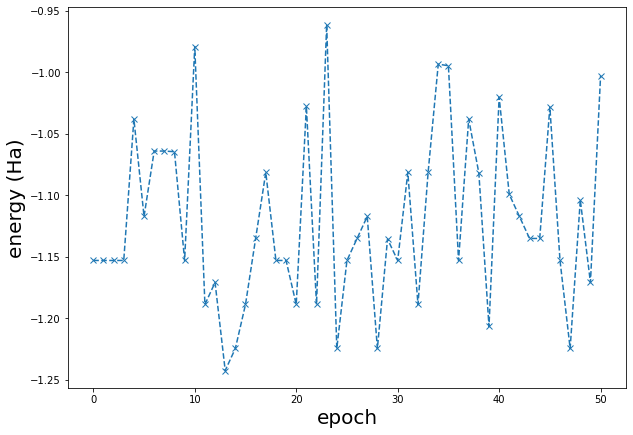

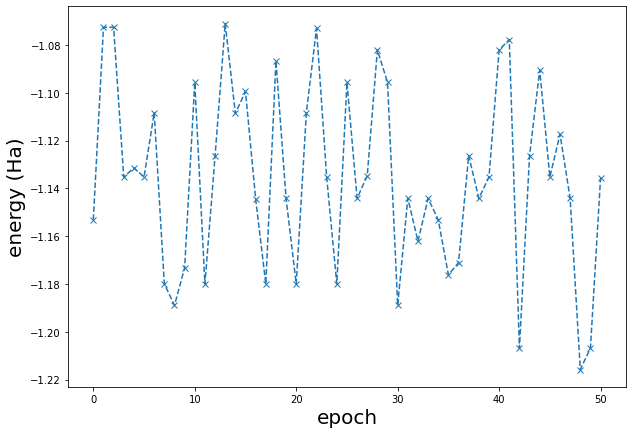

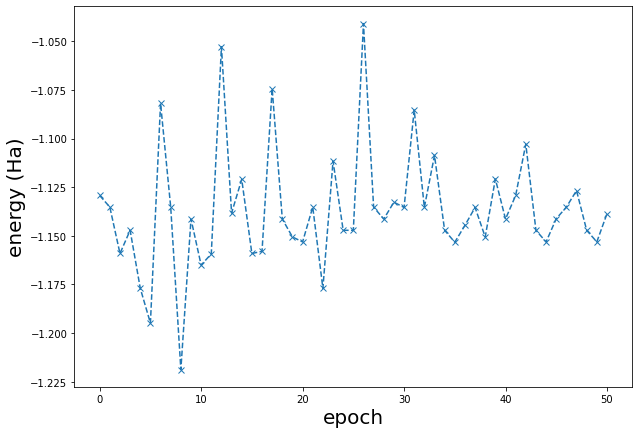

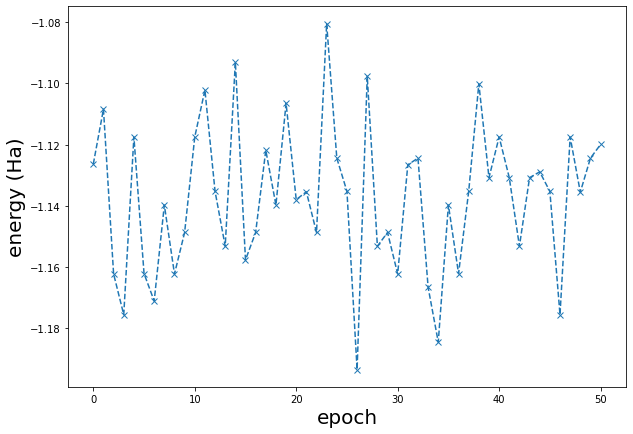

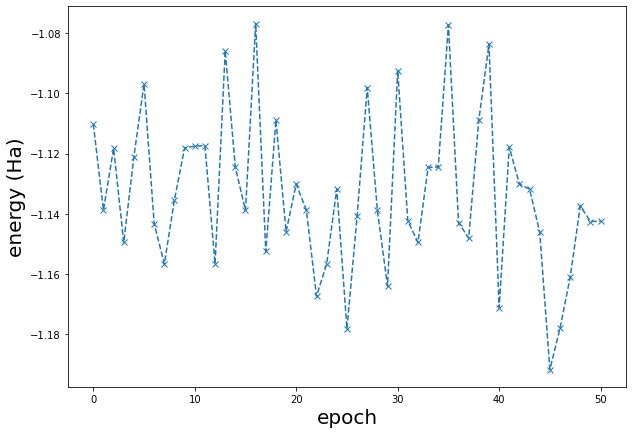

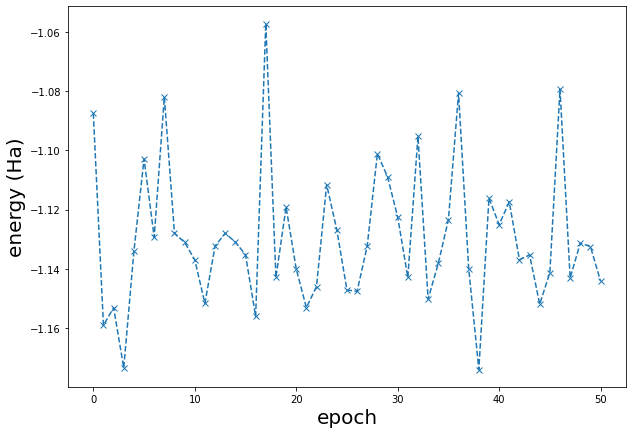

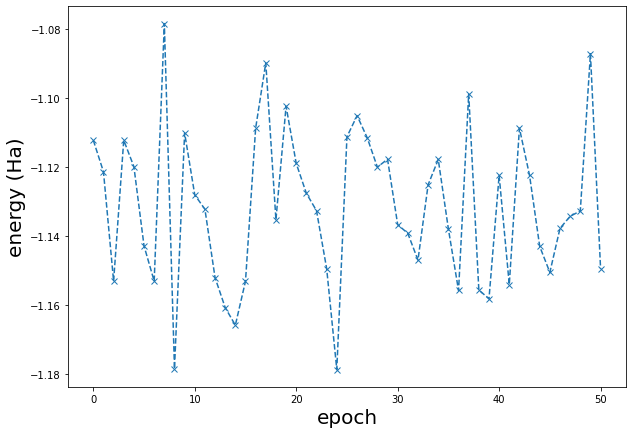

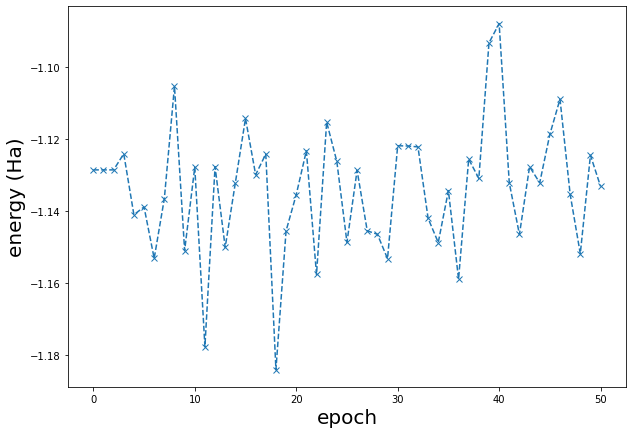

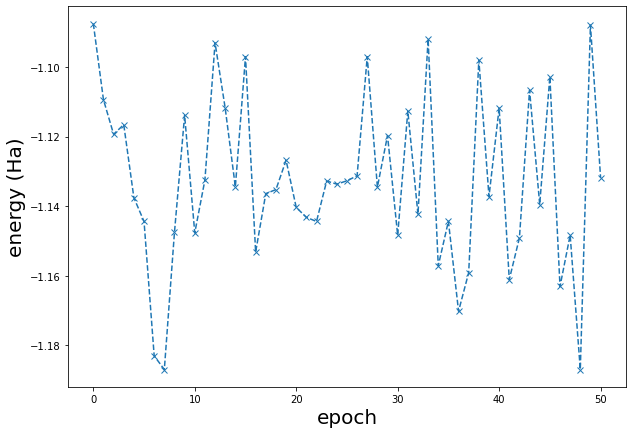

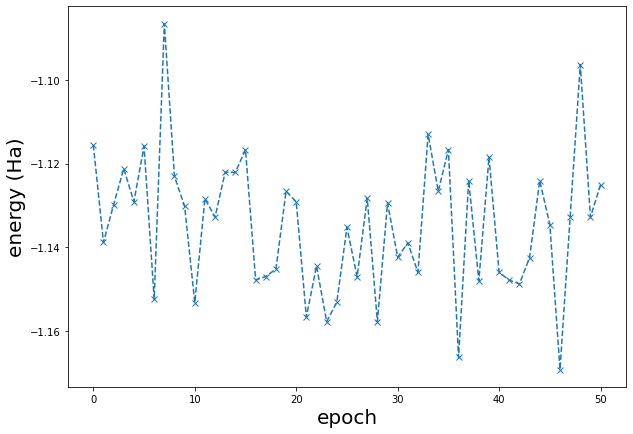

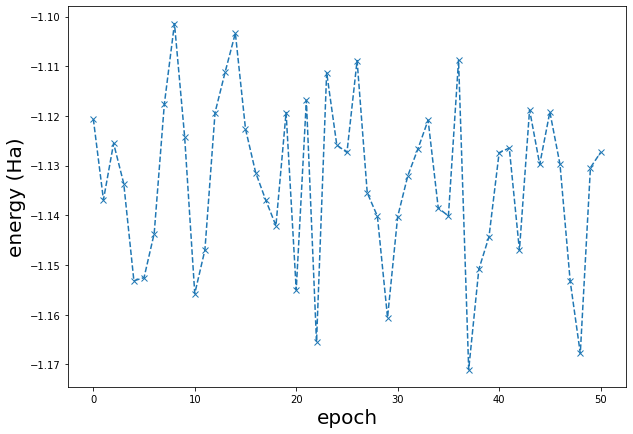

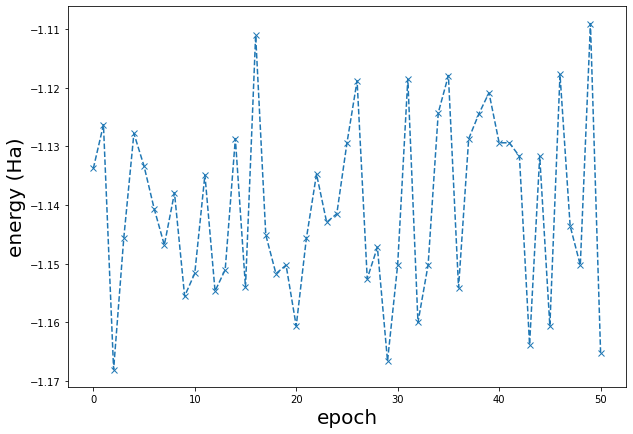

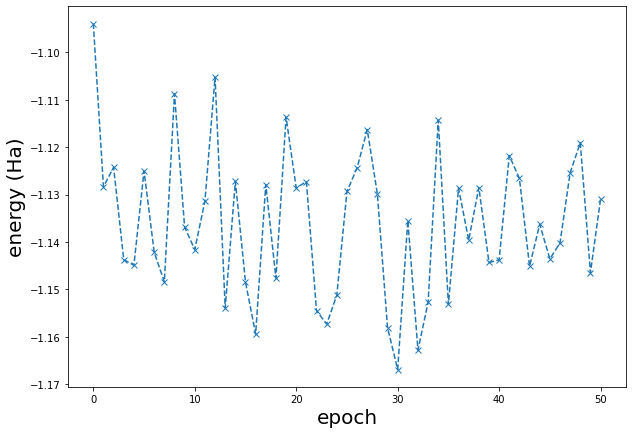

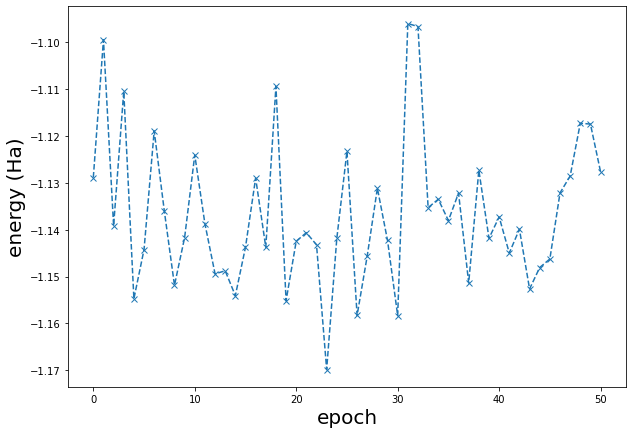

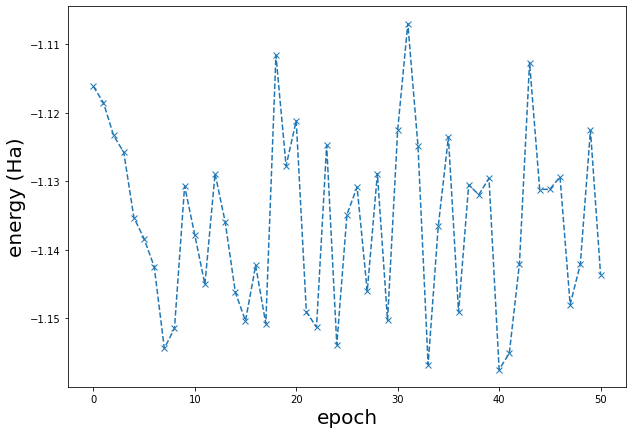

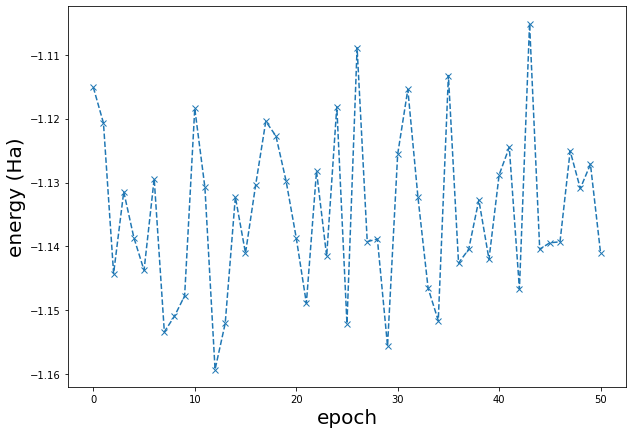

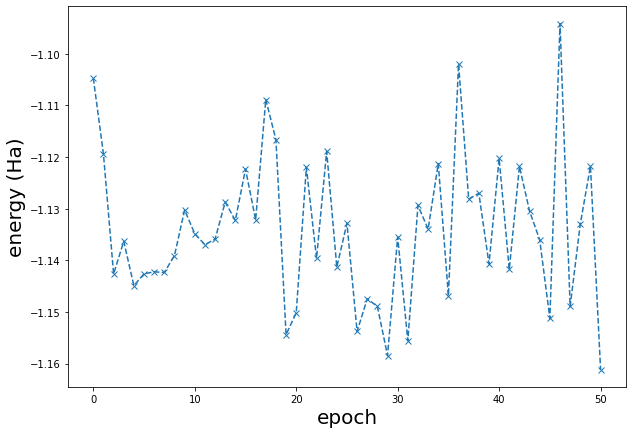

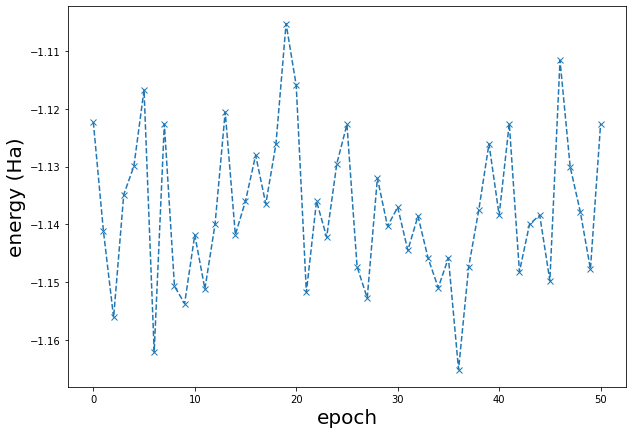

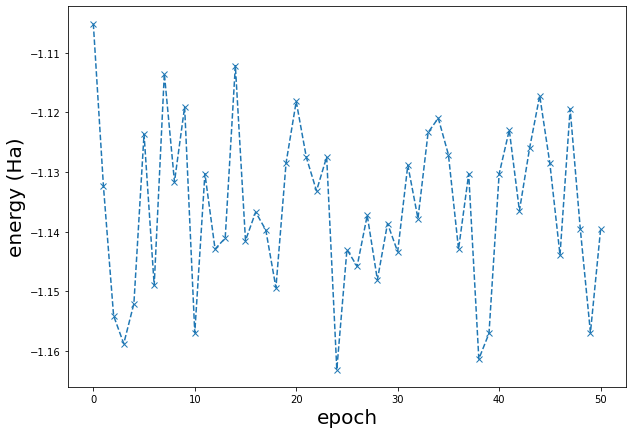

In [8]:
# Number of shots
num_shots_list = np.arange(5,100,5)

# Initialize params
energies_VQE = []
angles_VQE = []

# Define the cost function and the circuit
def circuit_VQE(theta, wires):
    qml.AllSinglesDoubles(
        weights = theta,
        wires = wires,
        hf_state = hf_state,
        singles = singles,
        doubles = doubles)
        
for num_shots in num_shots_list:
    
    print('---VQE for num. of samples %.0f---' %num_shots)
    
    num_shots = int(num_shots)

    # Define a device
    dev = qml.device('default.qubit', wires=qubits, shots=num_shots)

    @qml.qnode(dev)
    def cost_fn(theta):
        circuit_VQE(theta,range(qubits)) # Why define outside?
        return qml.expval(Hamiltonian)

    # Draw circuit
    # qml.drawer.use_style('black_white')
    # qml.draw_mpl(cost_fn, expansion_strategy="device")(np.zeros(num_theta))

    # Gradient descent optimization
    opt = qml.GradientDescentOptimizer(stepsize=stepsize)
    theta = np.zeros(num_theta, requires_grad=True)

    #  Initial energy
    energy = [cost_fn(theta)]
    angle = [theta]

    for n in range(max_iterations):

        theta, prev_energy = opt.step_and_cost(cost_fn, theta)

        energy.append(cost_fn(theta))
        angle.append(theta)

        conv = np.abs(energy[-1] - prev_energy)

        if n % 2 == 0:
            print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
    print("\n" f"Optimal values of the circuit parameter =, ", angle[-1])

    
    # Plot epochs
    plt.figure(figsize=(10,7))
    plt.plot(energy ,"x--")
    plt.xlabel("epoch", fontsize=20)
    plt.ylabel("energy (Ha)", fontsize=20)
    
    # Append energies and optimized thetas
    energies_VQE.append(energy[-1])
    angles_VQE.append(angle[-1])

In [11]:
# Obtain HF energy
binary_string = ''.join([str(i) for i in hf_state])
idx0 = int(binary_string, 2)
H11 = fermionic_Hamiltonian[idx0][idx0]

# Circuit that maps a product state
def circuit_product_state(state):
    qml.BasisState(state, range(qubits))
    
# Initialize params
energies_CBVQE = []
    
for i, num_shots in enumerate(num_shots_list):

    # Obtain VQE energy and optimized thetas
    H22 = energies_VQE[i]
    theta_opt = angles_VQE[i]
    
    # Get crossed terms
    wires = range(qubits + 1)
    dev = qml.device("default.qubit", wires=wires, shots=int(num_shots))
    Vcl = np.identity(2**qubits)
    Vq = qml.matrix(circuit_VQE)(theta_opt, range(qubits))

    @qml.qnode(dev)
    def hadamard_test(Vq, Vcl, W, component='real'):

        if component == 'imag':
            qml.RX(math.pi/2, wires=a_wires)

        qml.Hadamard(wires=[0])
        qml.QubitUnitary(W, wires=wires[1:])
        qml.ControlledQubitUnitary(Vq.conjugate().T @ Vcl, control_wires=[0], wires=wires[1:])
        qml.Hadamard(wires=[0])

        return qml.probs(wires=[0])

    # Compute crossed terms
    H12 = 0
    basis_states = np.array([[1,1,0,0], [0,1,1,0], [1,0,0,1], [0,0,1,1]], requires_grad=True)
    for i, basis_state in enumerate(basis_states):
        W = qml.matrix(circuit_product_state)(basis_state)
        probs = hadamard_test(Vq, Vcl, W)
        y = 2*abs(probs[0])-1
        binary_string = ''.join([str(i) for i in basis_state])
        idx = int(binary_string, 2)
        overlap_H = fermionic_Hamiltonian[idx0][idx]
        H12 += y*overlap_H
        if i == 0:
            y0 = y
    
    H21 = np.conjugate(H12)

    S = np.array([[1, y0],[y0, 1]])
    H = np.array([[H11, H12],[H21, H22]])
    
    evals = linalg.eigvals(H, S)
    
    energies_CBVQE.append(np.min(evals))

Text(0, 0.5, 'energy (Ha)')

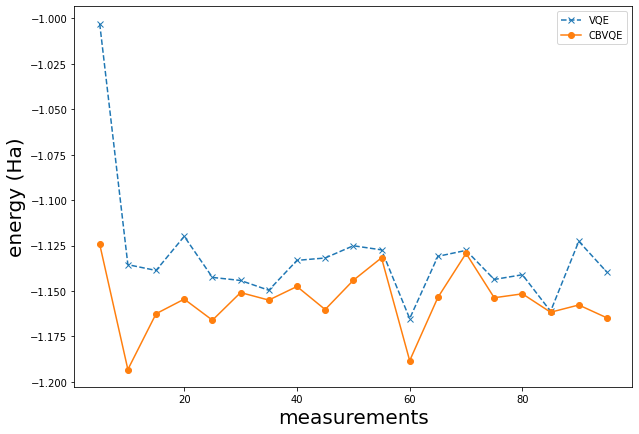

In [12]:
# Plot results
plt.figure(figsize=(10,7))
plt.plot(num_shots_list, energies_VQE,"x--", label='VQE')
plt.plot(num_shots_list, energies_CBVQE,"o-", label='CBVQE')
plt.legend()
plt.xlabel("measurements", fontsize=20)
plt.ylabel("energy (Ha)", fontsize=20)

In [18]:
# Print actual GS energy (diagonalize fermionic Hamiltonian)
from scipy.sparse.linalg import eigs
E0 = eigs(fermionic_Hamiltonian)[0][0]
print(np.real(E0))

-1.1361891624646876
